# Drosophila Graph

## Preprocessing

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
path = 'Drosophila/edges.csv'

edge_list = pd.read_csv(path)
print(edge_list.columns)


Index(['source', 'target', 'weight', 'layer'], dtype='object')


In [3]:
edge_list = edge_list.drop(columns=['weight', 'layer'])

edges = list(edge_list.itertuples(index=False, name=None))

G = nx.DiGraph()
G.add_edges_from(edges)

print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  42044
Number of nodes:  8215


In [4]:
largest_strongly = max(nx.strongly_connected_components(G), key=len)
G = G.subgraph(largest_strongly)

print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  31373
Number of nodes:  4149


## Strategies

The following section will shows the implementation of the different pivot selection strategies. We applied 5 different strategies:

1. Random
The random strategy selects nodes at random.

2. Random indegree
The random indegree strategy selects pivots with a probability proportional to their indegree

3. Random outdegree
The random outdegree strategy selects pivots with a probability proportional to their outdegree

4. Page rank based selection
The page rank based selection strategy select pivtos accoring to their page rank.

5. Mixed Strategy
The mixed strategy iterates through all startegies to select the pivots

In [5]:
def random_strategy(G, num_pivots):
    return np.random.choice(list(G.nodes), size=num_pivots, replace=False)

In [6]:
# Function for random selection based on in-degree
def ran_indeg_strategy(G, num_pivots):
    # Get the in-degree of each node
    indegrees = dict(G.in_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node in-degrees
    degree_sum = sum(indegrees.values())
    probabilities = [indegrees[node] / degree_sum for node in all_nodes]

    # Make sure that no node has a probability of 0
    non_zero_probabilities = [prob for prob in probabilities if prob > 0]
    lowest_value = min(non_zero_probabilities)
    adjustment_value = lowest_value * 0.9
    probabilities = [prob if prob > 0 else adjustment_value for prob in probabilities]

    total_prob_sum = sum(probabilities)
    probabilities = [prob / total_prob_sum for prob in probabilities]

    
    # Randomly select pivots with probability proportional to their in-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [7]:
# Function for random selection based on out-degree
def ran_outdeg_strategy(G, num_pivots):
    # Get the out-degree of each node
    outdegrees = dict(G.out_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node out-degrees
    degree_sum = sum(outdegrees.values())
    probabilities = [outdegrees[node] / degree_sum for node in all_nodes]

    # Make sure that no node has a probability of 0
    non_zero_probabilities = [prob for prob in probabilities if prob > 0]
    lowest_value = min(non_zero_probabilities)
    adjustment_value = lowest_value * 0.9
    probabilities = [prob if prob > 0 else adjustment_value for prob in probabilities]

    total_prob_sum = sum(probabilities)
    probabilities = [prob / total_prob_sum for prob in probabilities]

    
    # Randomly select pivots with probability proportional to their out-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [8]:
def pagerank_pivot_selection(G, num_pivots):
    """
    Select pivots based on PageRank scores.
    
    Parameters:
    - G: NetworkX directed graph (DiGraph)
    - num_pivots: Number of pivots to select
    
    Returns:
    - List of pivot nodes
    """
    # Calculate PageRank scores
    pagerank_scores = nx.pagerank(G)
    
    # Sort nodes by PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    
    # Select the top nodes as pivots
    pivots = sorted_nodes[:num_pivots]
    return pivots

In [9]:
def mixed_strategy(G, num_pivots):

    strategies = [random_strategy, ran_indeg_strategy, 
              ran_outdeg_strategy, pagerank_pivot_selection]

    selected_pivots = set()
    strategy_count = len(strategies)
    
    strategy_iter = iter(strategies)
    
    while len(selected_pivots) < num_pivots:
        try:
            strategy = next(strategy_iter)
        except StopIteration:
            strategy_iter = iter(strategies)
            strategy = next(strategy_iter)

        remaining_pivots = num_pivots - len(selected_pivots)
        candidates = strategy(G, remaining_pivots)
        
        for pivot in candidates:
            if len(selected_pivots) < num_pivots:
                selected_pivots.add(pivot)
            else:
                break

    return list(selected_pivots)


## Metrics

In [10]:
def euclidean_distance(exact, estimated):
    """
    Compute the normalized Euclidean distance between two centrality dictionaries.
    
    Parameters:
    - exact: dict, exact centrality values
    - estimated: dict, estimated centrality values
    
    Returns:
    - float, the normalized Euclidean distance
    """
    exact_values = np.array([exact[node] for node in exact])
    estimated_values = np.array([estimated[node] for node in exact])  # Ensure consistent order
    
    # Compute the Euclidean distance
    raw_distance = np.linalg.norm(exact_values - estimated_values)
    
    # Normalize by the magnitude of the exact centrality values
    normalization_factor = np.linalg.norm(exact_values)
    if normalization_factor == 0:  # Handle edge case where exact values are all zeros
        return 0.0
    
    return raw_distance / normalization_factor


In [11]:
from itertools import combinations

def compute_inversion_distance(exact_scores, estimated_scores):
    # Rank the nodes based on scores (higher scores get lower ranks)
    exact_ranking = sorted(exact_scores.items(), key=lambda x: x[1], reverse=True)
    estimated_ranking = sorted(estimated_scores.items(), key=lambda x: x[1], reverse=True)

    # Create dictionaries to map nodes to their ranks
    exact_ranks = {node: rank for rank, (node, _) in enumerate(exact_ranking, 1)}
    estimated_ranks = {node: rank for rank, (node, _) in enumerate(estimated_ranking, 1)}

    # Count inversions
    inversion_count = 0
    for u, v in combinations(exact_scores.keys(), 2):  # Compare all pairs of nodes
        exact_order = exact_ranks[u] - exact_ranks[v]  # Positive if u ranks higher than v
        estimated_order = estimated_ranks[u] - estimated_ranks[v]  # Positive if u ranks higher than v
        
        if exact_order * estimated_order < 0:  # Orders are inverted
            inversion_count += 1

    return inversion_count


In [12]:
exact_closeness = nx.closeness_centrality(G)
exact_betweenness = nx.betweenness_centrality(G)

print(exact_closeness)
print(exact_betweenness)

{0: 0.17091058920477956, 1: 0.2587163974303, 16: 0.1869900374160393, 21: 0.22723786567327708, 173: 0.2690885501135258, 670: 0.1969984802431611, 833: 0.24653789004457652, 994: 0.21202208137395215, 1317: 0.20255884363707394, 2273: 0.22867853795688847, 4254: 0.20974919093851133, 4255: 0.2076283912303534, 4256: 0.17273976596010493, 4257: 0.18270713121613882, 6483: 0.16676047278282544, 6484: 0.2326677137087727, 1769: 0.2061322864384038, 3549: 0.2440430664234865, 3847: 0.2613901317033209, 6266: 0.20559080095162569, 2: 0.21926207844381013, 3: 0.17985517929150588, 249: 0.2620506664981995, 3060: 0.21192458999642363, 2215: 0.22531233025529604, 2363: 0.17571803778700332, 4: 0.20120294916569656, 5: 0.20763878460229263, 6: 0.1691542288557214, 1611: 0.21101897542860049, 1687: 0.18555963138588172, 2397: 0.20234146341463416, 2477: 0.1990307566815412, 3277: 0.2062860553013726, 3629: 0.18390600753713146, 4259: 0.23436352336290187, 4260: 0.16754180466919782, 6927: 0.2017411604493945, 368: 0.2168662100695

In [13]:
sorted_closeness = dict(sorted(exact_closeness.items()))
sorted_betweenness = dict(sorted(exact_betweenness.items()))

print(sorted_closeness)

{0: 0.17091058920477956, 1: 0.2587163974303, 2: 0.21926207844381013, 3: 0.17985517929150588, 4: 0.20120294916569656, 5: 0.20763878460229263, 6: 0.1691542288557214, 8: 0.21849978929624947, 9: 0.1719805962104565, 12: 0.22331090174966353, 13: 0.18258649529007837, 14: 0.21436692506459948, 15: 0.2067281335659108, 16: 0.1869900374160393, 17: 0.23609767203597246, 18: 0.2752305752770221, 21: 0.22723786567327708, 24: 0.22114410620035188, 27: 0.21781138416299098, 30: 0.21464424320827943, 31: 0.21767422334172964, 32: 0.18167484232655923, 34: 0.16962460129222212, 36: 0.19278676333891057, 37: 0.15613354913991043, 38: 0.22846441947565543, 40: 0.21363823650597447, 45: 0.14140105675813874, 47: 0.21760570769069354, 48: 0.2633483588343597, 49: 0.19302000930665425, 50: 0.27710601910615273, 53: 0.15961212867477298, 54: 0.2557967439565861, 55: 0.2102915082382763, 56: 0.22942477876106196, 57: 0.24633291763168835, 63: 0.19614147909967847, 64: 0.21455542336936845, 66: 0.2437132784958872, 67: 0.250316818538410

In [14]:
all_shortest_paths = dict(nx.all_pairs_all_shortest_paths(G))

## Closeness Centrality

1. Select pivots according to the pivot selection strategies
2. Compute distance from pivot to all other nodes in G (d(pivot, node)) for out-closeness centrality.
3. Calculate the sum of all shortest paths
4. Devide the number of pivots by the sum from step 3

In [15]:
pivots = G.nodes
approximated_closeness = {}
for pivot in pivots:
    num_reachable_nodes = 0
    distances = 0
    for node in G.nodes:
        if node in all_shortest_paths and pivot in all_shortest_paths[node]:
            d = len(all_shortest_paths[node][pivot][0]) - 1  # Subtract 1 to get the number of edges
            if d > 0:  # Ensure the distance is valid
                distances += d
                num_reachable_nodes += 1
    if distances > 0:  # Prevent division by zero
        approximated_closeness[pivot] = num_reachable_nodes / distances
    else:
        approximated_closeness[pivot] = 0  # Assign 0 or another default value when no distances are found

print(approximated_closeness)

{0: 0.17091058920477956, 1: 0.2587163974303, 16: 0.1869900374160393, 21: 0.22723786567327708, 173: 0.2690885501135258, 670: 0.1969984802431611, 833: 0.24653789004457652, 994: 0.21202208137395215, 1317: 0.20255884363707394, 2273: 0.22867853795688847, 4254: 0.20974919093851133, 4255: 0.2076283912303534, 4256: 0.17273976596010493, 4257: 0.18270713121613882, 6483: 0.16676047278282544, 6484: 0.2326677137087727, 1769: 0.2061322864384038, 3549: 0.2440430664234865, 3847: 0.2613901317033209, 6266: 0.20559080095162569, 2: 0.21926207844381013, 3: 0.17985517929150588, 249: 0.2620506664981995, 3060: 0.21192458999642363, 2215: 0.22531233025529604, 2363: 0.17571803778700332, 4: 0.20120294916569656, 5: 0.20763878460229263, 6: 0.1691542288557214, 1611: 0.21101897542860049, 1687: 0.18555963138588172, 2397: 0.20234146341463416, 2477: 0.1990307566815412, 3277: 0.2062860553013726, 3629: 0.18390600753713146, 4259: 0.23436352336290187, 4260: 0.16754180466919782, 6927: 0.2017411604493945, 368: 0.2168662100695

In [16]:
print(len(approximated_closeness))

4149


In [17]:
def run_strategy(G, strategy, num_pivots, all_shortest_paths):
    pivots = strategy(G, num_pivots)
    approximated_closeness = {}
    
    for node in G.nodes:
        num_reachable_nodes = 0
        distances = 0
        
        for pivot in pivots:
            if pivot in all_shortest_paths and node in all_shortest_paths[pivot]:
                d = len(all_shortest_paths[pivot][node][0]) - 1 
                if d > 0:  
                    distances += d
                    num_reachable_nodes += 1
        if distances > 0:
            approximated_closeness[node] = num_reachable_nodes / distances
        else:
            approximated_closeness[node] = 0 
    
    return approximated_closeness


In [18]:
random = run_strategy(G, random_strategy, 1000, all_shortest_paths)
indeg = run_strategy(G, ran_indeg_strategy, 1000, all_shortest_paths)
outdeg= run_strategy(G, ran_outdeg_strategy, 1000, all_shortest_paths)
pr = run_strategy(G, pagerank_pivot_selection, 10, all_shortest_paths)

pr

{0: 0.18867924528301888,
 1: 0.29411764705882354,
 16: 0.20833333333333334,
 21: 0.2631578947368421,
 173: 0.30303030303030304,
 670: 0.20833333333333334,
 833: 0.2777777777777778,
 994: 0.2222222222222222,
 1317: 0.22727272727272727,
 2273: 0.23809523809523808,
 4254: 0.22727272727272727,
 4255: 0.23255813953488372,
 4256: 0.18181818181818182,
 4257: 0.18867924528301888,
 6483: 0.1724137931034483,
 6484: 0.2702702702702703,
 1769: 0.23255813953488372,
 3549: 0.2777777777777778,
 3847: 0.29411764705882354,
 6266: 0.22727272727272727,
 2: 0.20833333333333334,
 3: 0.1724137931034483,
 249: 0.2777777777777778,
 3060: 0.23255813953488372,
 2215: 0.2777777777777778,
 2363: 0.18518518518518517,
 4: 0.24390243902439024,
 5: 0.23255813953488372,
 6: 0.19607843137254902,
 1611: 0.23255813953488372,
 1687: 0.2222222222222222,
 2397: 0.22727272727272727,
 2477: 0.2222222222222222,
 3277: 0.23255813953488372,
 3629: 0.2222222222222222,
 4259: 0.24390243902439024,
 4260: 0.19607843137254902,
 6927:

In [19]:
strategies = [random_strategy, ran_indeg_strategy, 
              ran_outdeg_strategy, pagerank_pivot_selection, mixed_strategy]

num_pivots_list = [int(len(G.nodes) / 20 * i) for i in range(1, 21)]
print(num_pivots_list)

[207, 414, 622, 829, 1037, 1244, 1452, 1659, 1867, 2074, 2281, 2489, 2696, 2904, 3111, 3319, 3526, 3734, 3941, 4149]


In [20]:
from tqdm import tqdm 

from tqdm import tqdm
import numpy as np

def run_experiment(G, strategies, num_pivots_list, all_shortest_paths, exact_closeness, runs=1):
    results = {}

    for strategy in strategies:
        results[strategy.__name__] = {}
        for num_pivots in num_pivots_list:
            euclidean_distances = []
            inversions = []

            for _ in tqdm(range(runs), desc=f"Running {strategy.__name__} with {num_pivots} pivots"):
                # Run the strategy and calculate approximated closeness
                appr_closeness = run_strategy(G, strategy, num_pivots, all_shortest_paths)

                # Calculate metrics
                eucl_dist = euclidean_distance(exact_closeness, appr_closeness)
                inversion = compute_inversion_distance(exact_closeness, appr_closeness)

                # Collect results
                euclidean_distances.append(eucl_dist)
                inversions.append(inversion)

            # Store the average results
            avg_eucl_dist = np.mean(euclidean_distances)
            avg_inversion = np.mean(inversions)

            results[strategy.__name__][num_pivots] = {
                'average_euclidean_distance': avg_eucl_dist,
                'average_inversion_number': avg_inversion
            }

    return results

results = run_experiment(G, strategies, num_pivots_list, all_shortest_paths, exact_closeness)

Running pagerank_pivot_selection with 829 pivots: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
Running pagerank_pivot_selection with 1037 pivots: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]
Running pagerank_pivot_selection with 1244 pivots: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
Running pagerank_pivot_selection with 1452 pivots: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]
Running pagerank_pivot_selection with 1659 pivots: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]
Running pagerank_pivot_selection with 1867 pivots: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
Running pagerank_pivot_selection with 2074 pivots: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]
Running pagerank_pivot_selection with 2281 pivots: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]
Running pagerank_pivot_selection with 2489 pivots: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]
Running pagerank_pivot_selection with 2696 pivots: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]
Running pagerank_pivot_selectio

In [21]:
print(results)

{'random_strategy': {207: {'average_euclidean_distance': 0.010229177467649675, 'average_inversion_number': 160835.0}, 414: {'average_euclidean_distance': 0.007279331528565909, 'average_inversion_number': 125397.0}, 622: {'average_euclidean_distance': 0.008332310318836638, 'average_inversion_number': 106412.0}, 829: {'average_euclidean_distance': 0.011026060860994136, 'average_inversion_number': 81195.0}, 1037: {'average_euclidean_distance': 0.006185247523338531, 'average_inversion_number': 63189.0}, 1244: {'average_euclidean_distance': 0.0037005287508304176, 'average_inversion_number': 57133.0}, 1452: {'average_euclidean_distance': 0.004139913580569758, 'average_inversion_number': 48631.0}, 1659: {'average_euclidean_distance': 0.00472800591522419, 'average_inversion_number': 51457.0}, 1867: {'average_euclidean_distance': 0.005093995936914932, 'average_inversion_number': 44847.0}, 2074: {'average_euclidean_distance': 0.002449062863767538, 'average_inversion_number': 37954.0}, 2281: {'av

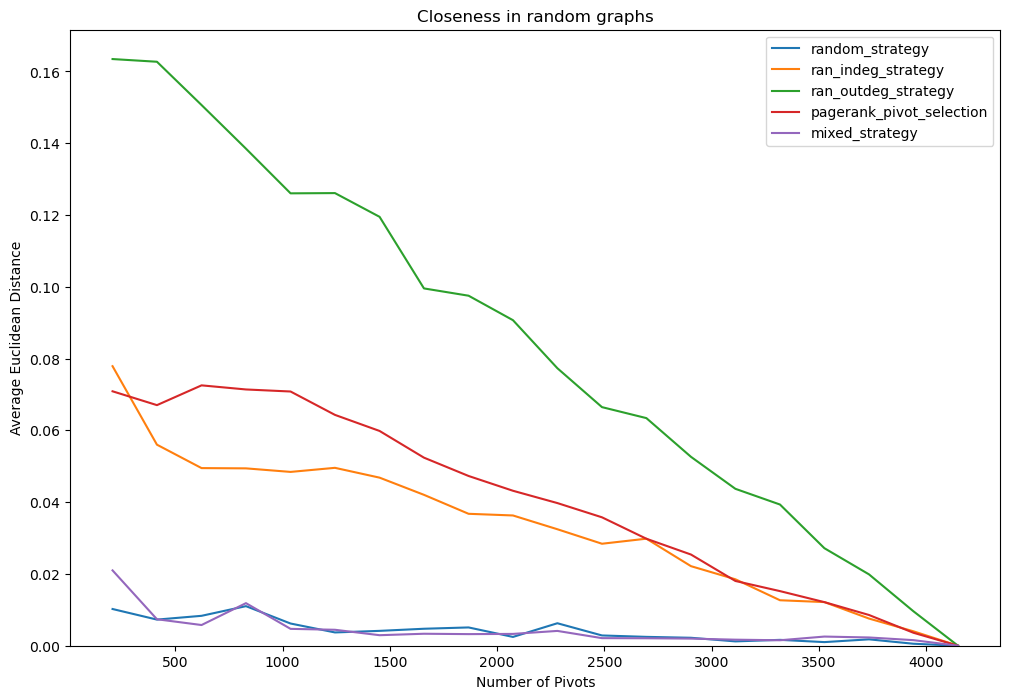

In [22]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["average_euclidean_distance"] for metrics in data.values()]  # Extract Euclidean distance
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Closeness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.show()

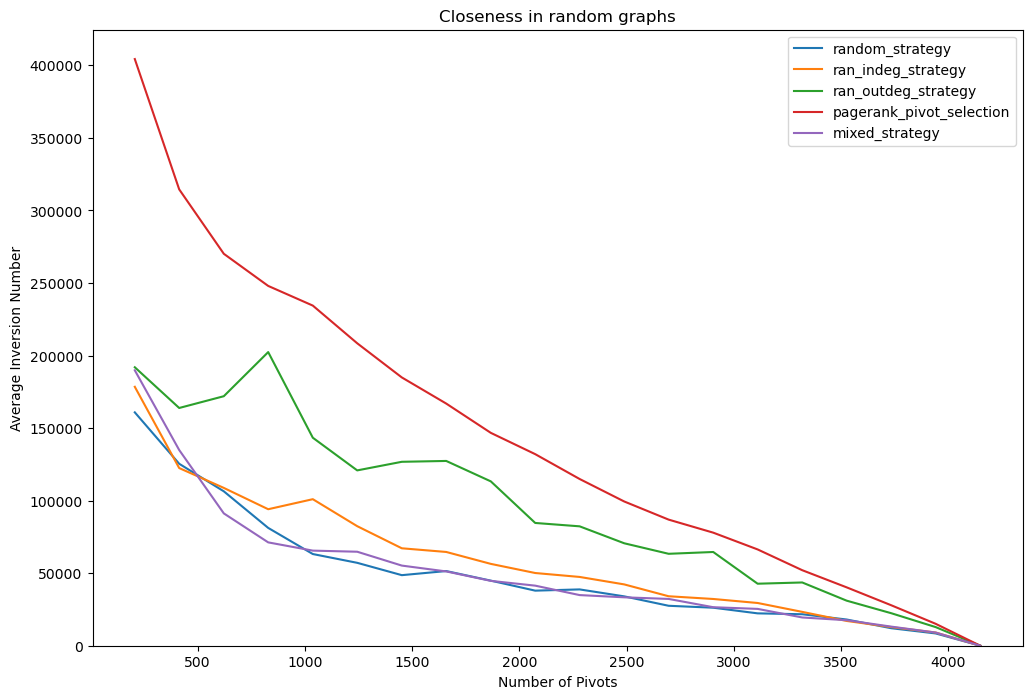

In [23]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["average_inversion_number"] for metrics in data.values()]  # Extract Inversion number
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Inversion Number")
plt.title("Closeness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.show()


## Betweenness

1. Select pivots according to the selection strategies
2. Access the shortest path from each pivot to all other nodes in the graph from the precomputed shortest paths
3. For each node v track how many shortest paths run through v
4. Sum the contributions of each node and normalize the aggregated betweenness centrality values by dividing by the total number of pivots 

In [24]:
print(exact_betweenness)
print(len(all_shortest_paths))

{0: 0.00017868559496228272, 1: 0.0019346831889894209, 16: 0.0016895670631869736, 21: 0.010136736787436347, 173: 0.00250228142587996, 670: 0.0005498501049669509, 833: 0.0026364925633795265, 994: 0.0034502088026952833, 1317: 0.0002324291958163445, 2273: 0.0014644389670099049, 4254: 0.0005571880548185896, 4255: 0.00036632201720828594, 4256: 0.00030895457520532116, 4257: 3.609475517702644e-05, 6483: 3.01389818639888e-06, 6484: 0.00029013116599760775, 1769: 0.0003812689944428516, 3549: 0.000561010405536217, 3847: 0.0057024220312842724, 6266: 7.457693289186179e-06, 2: 0.00275794113352211, 3: 0.00016092811243673168, 249: 0.009884813996107347, 3060: 0.0005483590149148342, 2215: 0.002743889789975349, 2363: 0.0007750154236945938, 4: 0.0009253773479002463, 5: 0.0007055875110553145, 6: 2.8496513236488032e-06, 1611: 0.0006128911601798653, 1687: 0.00038251248725862256, 2397: 0.001188001163013375, 2477: 0.00014874407197965279, 3277: 0.0001447880194937093, 3629: 0.00016494351118370872, 4259: 0.0023608

In [25]:
first_two = dict(list(all_shortest_paths.items())[:2])
print(first_two)

{0: {0: [[0]], 1: [[0, 1]], 16: [[0, 16]], 21: [[0, 21]], 173: [[0, 173]], 670: [[0, 670]], 833: [[0, 833]], 994: [[0, 994]], 1317: [[0, 1317]], 2273: [[0, 2273]], 4254: [[0, 4254]], 4255: [[0, 4255]], 4256: [[0, 4256]], 4257: [[0, 4257]], 6483: [[0, 6483]], 6484: [[0, 6484]], 1769: [[0, 1769]], 3549: [[0, 1, 3549]], 3847: [[0, 1, 3847]], 6266: [[0, 1, 6266]], 2: [[0, 16, 4267, 5461, 2], [0, 16, 4273, 5419, 2], [0, 4255, 4273, 5419, 2], [0, 21, 3277, 5419, 2], [0, 4254, 3277, 5419, 2]], 3: [[0, 16, 4267, 5461, 2, 3], [0, 16, 4273, 5419, 2, 3], [0, 4255, 4273, 5419, 2, 3], [0, 21, 3277, 5419, 2, 3], [0, 4254, 3277, 5419, 2, 3]], 249: [[0, 670, 249]], 3060: [[0, 21, 1283, 369, 3060]], 2215: [[0, 16, 1139, 2215], [0, 670, 2285, 2215]], 2363: [[0, 16, 2128, 38, 769, 2363], [0, 16, 2128, 354, 769, 2363], [0, 16, 2128, 768, 769, 2363], [0, 16, 2128, 2625, 769, 2363], [0, 16, 2128, 4726, 769, 2363], [0, 16, 2128, 6962, 769, 2363], [0, 16, 2128, 7752, 769, 2363], [0, 16, 2128, 7760, 769, 2363]

In [26]:
print(len(all_shortest_paths[0][2]))

5


In [27]:
pivots = G.nodes
num_nodes = len(G.nodes)
num_all_shortest_paths = len(all_shortest_paths)
approximated_betweenness = {node: 0 for node in G.nodes}
for pivot in pivots:
    for node in G.nodes:
        if node == pivot:
            continue
        num_paths = len(all_shortest_paths[pivot][node])
        for shortest_path in all_shortest_paths[pivot][node]:
            for i in range(1, len(shortest_path)-1):
                contributor = shortest_path[i]
                approximated_betweenness[contributor] += (1 / ((num_nodes-1)*(num_nodes-2)*num_paths))
print(approximated_betweenness)

{0: 0.000178685594962305, 1: 0.0019346831889888263, 16: 0.0016895670631867363, 21: 0.010136736787472045, 173: 0.002502281425879549, 670: 0.0005498501049670474, 833: 0.002636492563379701, 994: 0.0034502088026968553, 1317: 0.00023242919581637302, 2273: 0.0014644389670096232, 4254: 0.0005571880548187169, 4255: 0.00036632201720837636, 4256: 0.00030895457520538686, 4257: 3.609475517702638e-05, 6483: 3.0138981863988776e-06, 6484: 0.0002901311659976672, 1769: 0.00038126899444296, 3549: 0.0005610104055363326, 3847: 0.005702422031286306, 6266: 7.457693289186161e-06, 2: 0.0027579411335212516, 3: 0.00016092811243675014, 249: 0.009884813996150037, 3060: 0.0005483590149149562, 2215: 0.0027438897899755435, 2363: 0.0007750154236944771, 4: 0.00092537734790006, 5: 0.0007055875110552895, 6: 2.8496513236488015e-06, 1611: 0.0006128911601798564, 1687: 0.0003825124872587112, 2397: 0.001188001163013173, 2477: 0.0001487440719796651, 3277: 0.00014478801949372008, 3629: 0.00016494351118372696, 4259: 0.002360893

In [28]:
def run_strategy_betweenness(G, strategy, num_pivots, all_shortest_paths):
    pivots = strategy(G, num_pivots)
    num_nodes = len(G.nodes)
    approximated_betweenness = {node: 0 for node in G.nodes}
    scaling_factor = num_nodes / num_pivots

    for pivot in pivots:
        for node in G.nodes:
            if node == pivot:
                continue
            num_paths = len(all_shortest_paths[pivot][node])
            for shortest_path in all_shortest_paths[pivot][node]:
                for i in range(1, len(shortest_path)-1):
                    contributor = shortest_path[i]
                    approximated_betweenness[contributor] += scaling_factor * (1 / ((num_nodes-1)*(num_nodes-2)*num_paths))
    return approximated_betweenness

In [29]:
test = run_strategy_betweenness(G, ran_indeg_strategy, 900, all_shortest_paths)
print(test)
dist = euclidean_distance(exact_betweenness, test)
dist

KeyboardInterrupt: 

In [ ]:
strategies = [random_strategy, ran_indeg_strategy, 
              ran_outdeg_strategy, pagerank_pivot_selection, mixed_strategy]

num_pivots_list = [int(len(G.nodes) / 20 * i) for i in range(1, 21)]
print(num_pivots_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


In [ ]:
from tqdm import tqdm
import numpy as np

def run_experiment_betweenness(G, strategies, num_pivots_list, all_shortest_paths, exact_betweenness, runs=1):
    results = {}

    for strategy in strategies:
        results[strategy.__name__] = {}
        for num_pivots in num_pivots_list:
            euclidean_distances = []
            inversions = []

            for _ in tqdm(range(runs), desc=f"Running {strategy.__name__} with {num_pivots} pivots"):
                approximated_betweenness = run_strategy_betweenness(G, strategy, num_pivots, all_shortest_paths)

                eucl_dist = euclidean_distance(exact_betweenness, approximated_betweenness)
                inversion = compute_inversion_distance(exact_betweenness, approximated_betweenness)

                euclidean_distances.append(eucl_dist)
                inversions.append(inversion)

            avg_eucl_dist = np.mean(euclidean_distances)
            avg_inversion = np.mean(inversions)

            results[strategy.__name__][num_pivots] = {
                'euclidean_distance': avg_eucl_dist,
                'inversion_number': avg_inversion
            }

    return results


results_betweenness = run_experiment_betweenness(G, strategies, num_pivots_list, all_shortest_paths, exact_betweenness)

Running random_strategy with 150 pivots:  10%|█         | 2/20 [00:00<00:03,  4.91it/s]

Running ran_outdeg_strategy with 900 pivots:  20%|██        | 4/20 [00:04<00:16,  1.05s/it]

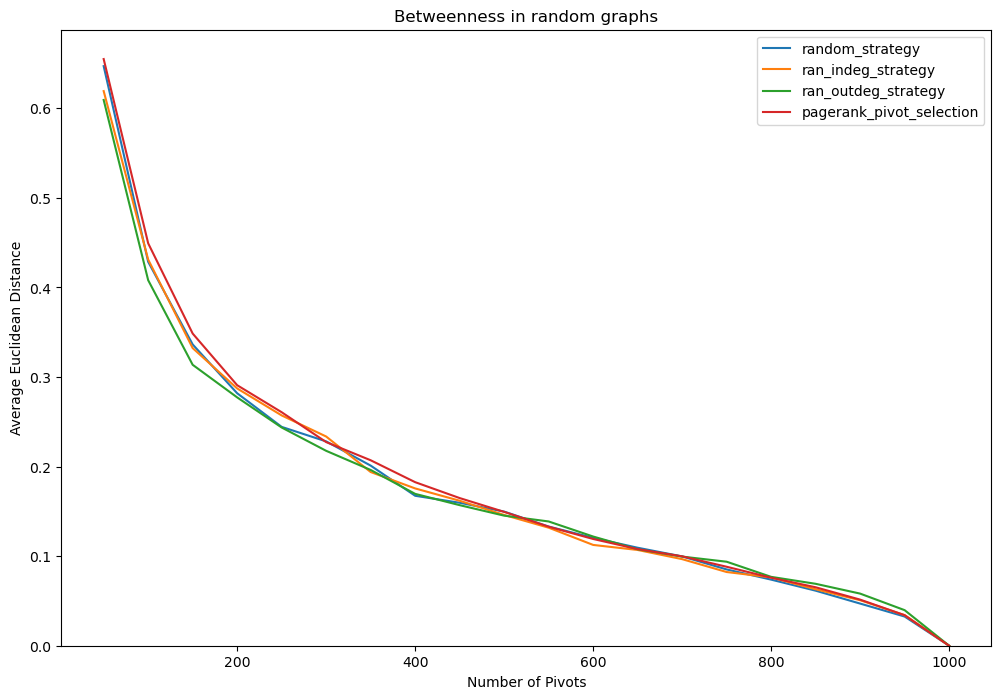

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results_betweenness.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["euclidean_distance"] for metrics in data.values()]  # Extract Euclidean distance
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Betweenness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.show()

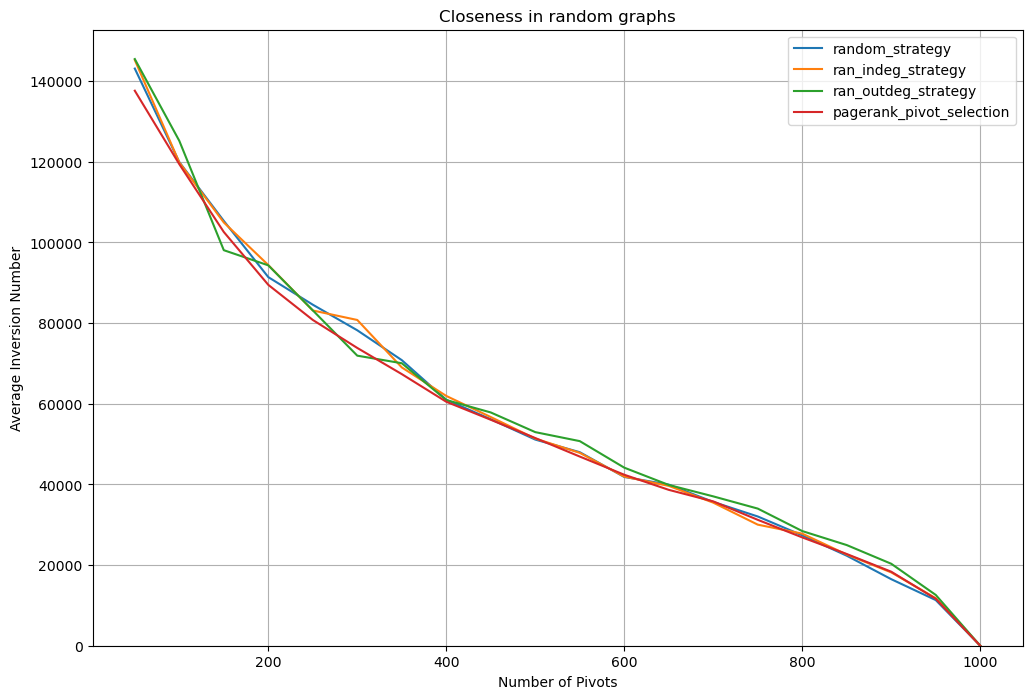

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results_betweenness.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["inversion_number"] for metrics in data.values()]  # Extract Inversion number
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Inversion Number")
plt.title("Closeness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.show()